In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

from sklearn.datasets import make_classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import tboost

In [36]:
import targen

In [37]:
tboost.__path__

['/Users/sandro/Analytics/Packages/TransferBoost/tboost']

In [38]:
from helpers import gen_samples, setup_logging, shift_features, psi

setup_logging()

In [39]:
data_raw = gen_samples(n_samples = 10, n_exp = 1, n_unif =1, n_normal = 1)
# data_raw = data_raw.reset_index().rename(columns={"index":"time_col"})

2021-03-01 22:00:21 - INFO - gen_samples: Generating 1 exponential features with 10 rows
2021-03-01 22:00:21 - INFO - gen_samples: Generating 1 uniform features with 10 rows
2021-03-01 22:00:21 - INFO - gen_samples: Generating 1 normal features with 10 rows


In [40]:
make_copy = lambda x: x.copy()

data = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data_raw.columns, min_max_scaler_range=(1,100))
)

features = [col for col in data_raw.columns if col.startswith("col_")]

In [47]:
data.columns = ['f1','f2','f3']
data = data.apply(lambda x: np.round(x,2))

In [50]:
data.to_dict()

{'f1': {0: 100.0,
  1: 1.0,
  2: 32.24,
  3: 30.34,
  4: 21.67,
  5: 18.13,
  6: 39.8,
  7: 1.85,
  8: 27.53,
  9: 11.23},
 'f2': {0: 1.0,
  1: 15.98,
  2: 17.78,
  3: 18.86,
  4: 36.75,
  5: 12.79,
  6: 100.0,
  7: 76.07,
  8: 53.54,
  9: 47.09},
 'f3': {0: 82.1,
  1: 1.0,
  2: 72.77,
  3: 40.7,
  4: 14.61,
  5: 78.51,
  6: 97.11,
  7: 100.0,
  8: 61.48,
  9: 73.41}}

In [51]:
features

['col_exp_0', 'col_uni_0', 'col_norm_0']

# Add targets

In [9]:
from targen.data import target

In [68]:
interaction_terms_1 = "".join([
    "2.5*f1*f2",
    "-0.2*f2*f3",
    "+0.7*f1*f3",
    "-1.3*f3/f2", # the shift shoul reduce here the effect  
])

expressions_1 = {
    'linear': '-0.5*f1 + 2*f3 -3.2*f2',
    
    'interaction': interaction_terms_1,
    
    'uniform_noise': {
        'weight':107.7
    },
    'gaussian_noise': {
        'weight':15.4,
        'mu_gaus': -1.5
    }
}

In [69]:
data_y_1 = target.get_target_and_contributions(data, expressions=expressions_1, imbalance = 0.4, 
                                             drop_features=False)

In [70]:
{k:[val for val in v.values()]
 for k,v in data_y_1[['f1','f2','f3','y']].to_dict().items()
}

{'f1': [100.0, 1.0, 32.24, 30.34, 21.67, 18.13, 39.8, 1.85, 27.53, 11.23],
 'f2': [1.0, 15.98, 17.78, 18.86, 36.75, 12.79, 100.0, 76.07, 53.54, 47.09],
 'f3': [82.1, 1.0, 72.77, 40.7, 14.61, 78.51, 97.11, 100.0, 61.48, 73.41],
 'y': [0, 0, 1, 0, 0, 1, 0, 0, 1, 1]}

In [73]:
X, y = data_y_1[['f1']],data_y_1['y']

0
[22:23:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62500	validation_0-logloss:0.66763
[3]	validation_0-auc:0.72917	validation_0-logloss:0.65251


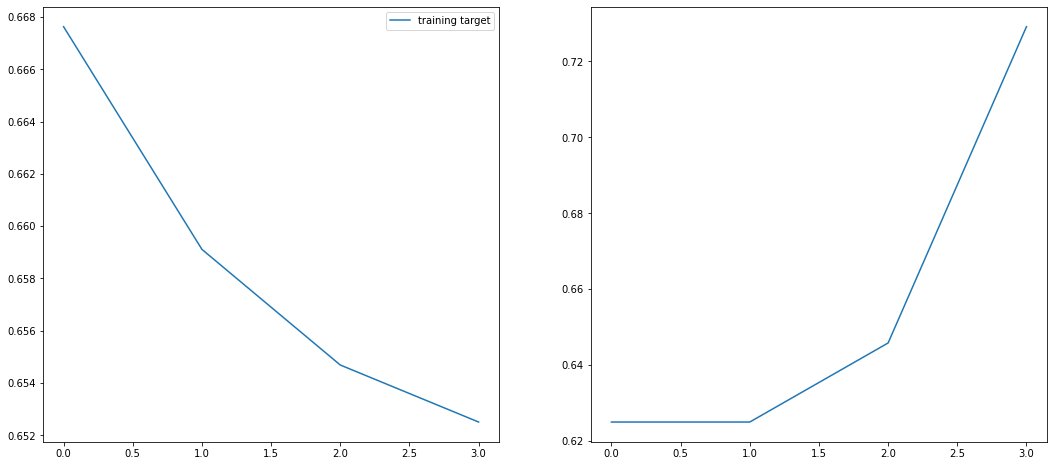

In [82]:
import xgboost as xgb

min_frac =int(0.05*X.shape[0])
print(min_frac)

model = xgb.XGBClassifier(
    max_depth = 2,
    reg_lambda = 0,
    num_leaves=4,
    n_estimators=4,
#     min_child_samples=min_frac,
    learning_rate=0.3
)

eval_set = [(X,y)]
model.fit(
    X,
    y,
    eval_metric=["auc","logloss"], 
#     eval_names = ['validation_0','validation_1'],
    eval_set=eval_set, 
    verbose=30, # after how many training sets you want the printout on the console
    early_stopping_rounds=39
)

fig, ax = plt.subplots(1,2,figsize=(18,8))


ax[0].plot(model.evals_result_['validation_0']['logloss'], label = "training target")
# ax[0].plot(model.evals_result_['validation_1']['logloss'], label = "test target")

ax[1].plot(model.evals_result_['validation_0']['auc'])
# ax[1].plot(model.evals_result_['validation_1']['auc'])
ax[0].legend()

In [83]:
from tboost.utils.boost import recompute_leaves, compute_probability

In [106]:
model_params

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 4,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'num_leaves': 4}

In [105]:
X_leafs = model.apply(X)
model_params = model.get_params()
display(X_leafs)

X_leaf_outputs = recompute_leaves(X_leafs, X, y, model_params=model_params)
#display the first three rows
np.round(X_leaf_outputs,4)

array([[2, 2, 2, 2],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [2, 2, 2, 2],
       [1, 2, 1, 1],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [1, 1, 1, 1],
       [1, 2, 2, 2],
       [1, 1, 1, 1]], dtype=int32)

start leaf = 0.0


array([[ 0.    , -0.3   , -0.1426, -0.0072, -0.0051],
       [ 0.    ,  0.    ,  0.    , -0.1116, -0.0785],
       [ 0.    , -0.3   , -0.1426, -0.0072, -0.0051],
       [ 0.    , -0.3   , -0.1426, -0.0072, -0.0051],
       [ 0.    ,  0.    , -0.1426, -0.1116, -0.0785],
       [ 0.    ,  0.    ,  0.    , -0.1116, -0.0785],
       [ 0.    , -0.3   , -0.1426, -0.0072, -0.0051],
       [ 0.    ,  0.    ,  0.    , -0.1116, -0.0785],
       [ 0.    ,  0.    , -0.1426, -0.0072, -0.0051],
       [ 0.    ,  0.    ,  0.    , -0.1116, -0.0785]])

In [99]:
bst = model.get_booster()

In [104]:
trees_df = bst.trees_to_dataframe()
trees_df[trees_df.Feature=="Leaf"]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
1,0,1,0-1,Leaf,NaN,NaN,NaN,NaN,-0.000000,1.500000
2,0,2,0-2,Leaf,NaN,NaN,NaN,NaN,-0.300000,1.000000
4,1,1,1-1,Leaf,NaN,NaN,NaN,NaN,-0.000000,1.000000
5,1,2,1-2,Leaf,NaN,NaN,NaN,NaN,-0.142553,1.477833
7,2,1,2-1,Leaf,NaN,NaN,NaN,NaN,-0.111574,1.248734
8,2,2,2-2,Leaf,NaN,NaN,NaN,NaN,-0.007230,1.201326
10,3,1,3-1,Leaf,NaN,NaN,NaN,NaN,-0.078530,1.242901
11,3,2,3-2,Leaf,NaN,NaN,NaN,NaN,-0.005070,1.199685


In [95]:
X_leaf_outputs.sum(axis=1)

array([-0.45485275, -0.1901041 , -0.45485275, -0.45485275, -0.33265671,
       -0.1901041 , -0.45485275, -0.1901041 , -0.15485275, -0.1901041 ])

In [94]:
model.predict(X,output_margin=True)

array([-0.45485273, -0.1901041 , -0.45485273, -0.45485273, -0.33265674,
       -0.1901041 , -0.45485273, -0.1901041 , -0.1548527 , -0.1901041 ],
      dtype=float32)

In [108]:
model_preds = None
for ix_tree in range(1,5):
    preds_ix = model.predict_proba(X, ntree_limit=ix_tree)[:,1].reshape(-1,1)
    if model_preds is None:
        model_preds = preds_ix
    else:
        model_preds = np.hstack([model_preds, preds_ix])
model_preds


array([[0.4255575 , 0.39113286, 0.38941234, 0.3882076 ],
       [0.5       , 0.5       , 0.47213534, 0.4526166 ],
       [0.4255575 , 0.39113286, 0.38941234, 0.3882076 ],
       [0.4255575 , 0.39113286, 0.38941234, 0.3882076 ],
       [0.5       , 0.46442208, 0.43680802, 0.4175943 ],
       [0.5       , 0.5       , 0.47213534, 0.4526166 ],
       [0.4255575 , 0.39113286, 0.38941234, 0.3882076 ],
       [0.5       , 0.5       , 0.47213534, 0.4526166 ],
       [0.5       , 0.46442208, 0.46262413, 0.461364  ],
       [0.5       , 0.5       , 0.47213534, 0.4526166 ]], dtype=float32)

In [91]:
np.array([0.3882076, 0.4526166, 0.3882076, 0.3882076, 0.4175943, 0.4526166,
       0.3882076, 0.4526166, 0.461364 , 0.4526166])

array([0.3882076, 0.4526166, 0.3882076, 0.3882076, 0.4175943, 0.4526166,
       0.3882076, 0.4526166, 0.461364 , 0.4526166])

In [89]:
compute_probability(X_leaf_outputs)

array([0.3882076 , 0.45261659, 0.3882076 , 0.3882076 , 0.41759435,
       0.45261659, 0.3882076 , 0.45261659, 0.46136399, 0.45261659])

array([1, 2], dtype=int32)

array([-0.14373387,  0.12600707])

<AxesSubplot:>

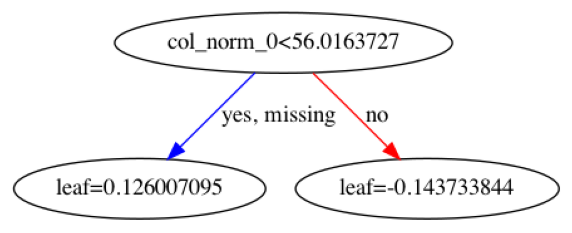

In [21]:
tree_index = 7

display(np.unique(X_leafs[:,tree_index+1]))
display(np.unique(X_leaf_outputs[:,tree_index+1]))

fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = tree_index)

# Run here the calculations

In [17]:
learning_rate = model_params["learning_rate"]
learning_rate

0.5

# Old stuff 

In [18]:
X_leaf_outputs = recompute_leaves(X_leafs, X, y, model_params=model_params)
#display the first three rows
X_leaf_outputs[:3]

start leaf = 0.0


array([[ 0.        , -1.        ,  0.5605147 ,  0.26686872, -0.06219737,
         0.15644076, -0.15201405,  0.17064259, -0.14373387,  0.15785242,
        -0.09867369],
       [ 0.        ,  0.6       , -0.29141195,  0.26686872, -0.06219737,
         0.15644076, -0.15201405,  0.17064259, -0.14373387,  0.15785242,
        -0.09867369],
       [ 0.        ,  0.6       ,  0.5605147 ,  0.05537248, -0.47601341,
         0.15644076, -0.15201405,  0.17064259, -0.14373387,  0.15785242,
        -0.09867369]])

In [19]:
prob_first_tree = compute_proability(X_leaf_outputs, learning_rate = 0.5, tree_index =1)

NameError: name 'compute_proability' is not defined

In [ ]:
g_1, h_1 = logloss(prob_first_tree,y)

In [ ]:
model_params['base_score']

In [ ]:
model.predict_proba(X, ntree_limit=1)[:,1]

In [ ]:
tree_index = 2

print("whole array")
display(model.predict(X,output_margin=True, ntree_limit = tree_index))

print("unqiues")
display(np.unique(model.predict(X,output_margin=True, ntree_limit = tree_index)))

fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = tree_index-1)

In [ ]:
X_leaf_outputs[:,1]

In [ ]:
# COmpare the tree outputs and our calculation

In [ ]:
X_leaf_outputs[:,(tree_index+1)]

In [ ]:
tree_index = 0

display(np.unique(X_leafs[:,tree_index+1]))
display(np.unique(X_leaf_outputs[:,tree_index+1]))

fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = tree_index)

# Test If I am able to reconstruct the values using the probabilities

In [ ]:
from tboost.utils.loss_functions import _sigmoid, _logistic, loss_from_leaves, logloss
from tboost.utils.boost import _calculate_leaf_values

In [ ]:
first_tree_pred = model.predict_proba(X, ntree_limit=2)[:,1]

In [ ]:
g, h = logloss(first_tree_pred, y)

In [ ]:
X_leafs[:,2]

In [ ]:
leaf_vals = _calculate_leaf_values(X_leafs, g, h, tree_index = 2, model_params=model_params)
leaf_vals

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = 2)

# try to compute the next tree values

In [ ]:
np.log(first_tree_pred/(1-first_tree_pred)) + leaf_vals

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = 3)

In [ ]:
X.shape

In [ ]:
model_params

In [ ]:
from tboost.utils.loss_functions import _sigmoid, _logistic

In [ ]:
model.predict_proba(X, ntree_limit=3)[:,1]

In [ ]:
_logistic(X_leaf_outputs[:,:4].sum(axis=1))

In [ ]:
# Check why the the 

In [ ]:
X_leaf_outputs[:,1]

In [ ]:
np.unique(X_leaf_outputs[:,1])

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = 3)

In [ ]:
from functools import reduce

def plot_proba_evol(X,y,model, max_n_trees=500):
    arrays = list()
    for ix in range(1,max_n_trees+1):
        try:
            pred_ix = model.predict_proba(X, num_iteration=ix)[:,1]
        except:
            pred_ix = model.predict_proba(X, ntree_limit=ix)[:,1]
        arrays.append(pred_ix)
    return np.transpose(reduce(lambda x,y: np.vstack((x,y)),arrays))        
        
    
def find_pred_trend(X,y,model, max_n_trees = 500):
    
    proba_trees = plot_proba_evol(X,y,model, max_n_trees=max_n_trees)
    
#     return proba_trees
    
    mean_y_0 = proba_trees[y.values==0].mean(axis=0)
    std_y_0 = proba_trees[y.values==0].std(axis=0)

    mean_y_1 = proba_trees[y.values==1].mean(axis=0)
    std_y_1 = proba_trees[y.values==1].std(axis=0)
    
    return mean_y_0, std_y_0, mean_y_1, std_y_1

In [ ]:
y.value_counts()

In [ ]:
mean_y_zero_train_1, std_y_zero_train_1, mean_y_one_train_1, std_y_one_train_1 = find_pred_trend(X,y,model,max_n_trees=10)
mean_y_zero_1, std_y_zero_1, mean_y_one_1, std_y_one_1 = find_pred_trend(X,y,model,max_n_trees=10)


x = [i for i in range(1, mean_y_zero_train_1.shape[0]+1)]

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(x,mean_y_zero_train_1, label = "y=0 train", color='orange', linestyle='--')
ax.fill_between(x, mean_y_zero_train_1-std_y_zero_train_1, mean_y_zero_train_1+std_y_zero_train_1, color='orange',alpha=0.2)

ax.plot(x,mean_y_one_train_1, label = "y=1 train", color='blue',linestyle='--')
ax.fill_between(x, mean_y_one_train_1-std_y_one_train_1, mean_y_one_train_1+std_y_zero_train_1, color='blue',alpha=0.2)
ax.plot(x,mean_y_zero_1, label = "y=0", color='orange')
ax.plot(x,mean_y_one_1, label = "y=1", color='blue')


ax.legend()

# ax[1].plot(std_y_zero_train_1, label = "y=0 train", color='orange', linestyle='--')
# ax[1].plot(std_y_one_train_1, label = "y=1 train", color='blue',linestyle='--')
# ax[1].plot(std_y_zero_1, label = "y=0", color='orange')
# ax[1].plot(std_y_one_1, label = "y=1", color='blue')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
xgb.plot_tree(model, ax = ax, num_trees = 0)

In [ ]:
Stop here

In [ ]:
model.learning_rate

In [ ]:
tree_index = 0
reg_lambda = 0
leaf_outs = {}
leaves = l[:,tree_index]
for leave_ix in np.unique(leaves):
    leaf_outs[leave_ix] = 0.3*g[leaves==leave_ix].sum()/(h[leaves==leave_ix].sum() + reg_lambda)
    
leaf_outs

In [ ]:
g[leaves==4].sum()